# 05: Estimate Effects

## Constants

Define constants that are used to determine the width of bins (`d_bin_size`) and the maximum distance up to which effects are estimated (`d_bin_max`), as well as a distance after which treatment effects are assumed to be 0 for the purpose of calculating standard errors (`dist_no_effect_var`).

In [1]:
d_bin_size <- 0.025
d_bin_max <- 0.25
num_bins <- ceiling(d_bin_max/d_bin_size)
dist_no_effect_var <- 0.10

## Required R packages

* `dplyr` for data management
* `tidyr` to replace na values in a column within a dplyr pipeline
* `ggplot2` to plot the estimates by distance
* `data.table` and `Rcpp` for (relatively) fast estimation of the variance of the estimator
* `spatial_treat_estimator.R` contains functions that estimate treatment effects and standard errors under additive separability of treatment effects with a known maximum distance after which treatment has no effect

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(data.table)
library(Rcpp)
source("spatial_treat_estimator.R")


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last




## Load and prepare ata

This script uses data computed by the previous scripts.
The following code loads the relevant data files and selects the outcome units, outcome variable, and distance measure used to estimate effects.

In [3]:
dat_A <- readRDS("data/dat_A.rds")
dat_S <- readRDS("data/dat_S.rds")
dat_D <- readRDS("data/dat_D.rds")
dat_cand_sel <- readRDS("data/dat_cand.rds")
dat_D_cand_sel <- readRDS("data/dat_D_cand.rds")
dat_S_treat <- readRDS("data/dat_reg_out_sel.rds")

# outcome units
dat_Y <- dat_A %>%
  # filter to get "Restaurants and Other Eating Places"
  filter(floor(naics_code/100) == 7225) %>% 
  mutate(Y = visits) %>% 
  select(a_id,Y)
# distance between outcome units and candidate locations
dat_D_IS <- rbind(dat_D,dat_D_cand_sel) %>% 
  # only need businesses that are outcome units
  filter(a_id %in% dat_Y$a_id) %>% 
  # and very large distances won't ever be considered
  filter(dist_mi < max(2*d_bin_max,dist_no_effect_var)) %>%
  # use distances in miles
  rename(d = dist_mi) %>% 
  select(a_id,s_id,d)

## Estimate and plot effects

Finally, we are ready to estimate effects.
The function `spatialTreat_loop` conveniently creates the distance bins of interest, loops over them, and returns a table that that includes one row for each estimate.

In [4]:
dat_out <- sptreat_loop(dat_D=dat_D_IS %>% rename(i=a_id,s=s_id),
             dat_S = dat_S_treat %>% rename(s=s_id),
             dat_Y = dat_Y %>% rename(i=a_id),
             dd = seq(d_bin_size/2,by=d_bin_size,length.out=num_bins),
             hh = d_bin_size,
             maxdeffect = dist_no_effect_var)
dat_out

dist_bin,d,tau_hat,se,muc,mut,nbart,nbarc,nbar,V,Vt,Vc,Vx
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.0125,6.0135756,7.188422,10.169351,16.182927,0.1704782,0.1738125,0.1704782,0.107429122,23.728551,26.999977,0.9448790
1,0.0375,5.2098092,5.359669,8.956858,14.166667,0.3492723,0.3666097,0.3492723,0.059721530,12.038059,16.485295,0.2027017
2,0.0625,4.5655168,4.795452,9.706857,14.272374,0.5343035,0.5559362,0.5343035,0.047809482,12.044464,10.454701,0.4971958
3,0.0875,3.0524932,5.384757,10.424700,13.477193,0.5925156,0.5315356,0.5925156,0.060281935,14.984726,13.547584,0.4633005
4,0.1125,2.3569852,2.976654,9.015837,11.372822,0.5966736,0.5724730,0.5966736,0.018420929,2.958298,5.216263,0.6859048
5,0.1375,1.7397471,3.386333,9.332667,11.072414,0.6029106,0.5904554,0.6029106,0.023840436,4.902510,4.501963,2.0627770
6,0.1625,3.0794547,3.071822,8.545545,11.625000,0.5488565,0.6040286,0.5488565,0.019617657,3.859190,4.216366,1.3605367
7,0.1875,2.2750877,2.776754,7.948317,10.223404,0.5862786,0.6123011,0.5862786,0.016029864,3.964671,2.624986,1.1207072
8,0.2125,0.5066464,2.063034,9.458605,9.965251,0.5384615,0.4969859,0.5384615,0.008848458,1.894412,1.828373,0.5333227


We can plot the estimates by distance bins, with error bars indicating the estimate plus or minus 1.96 times the standard error.

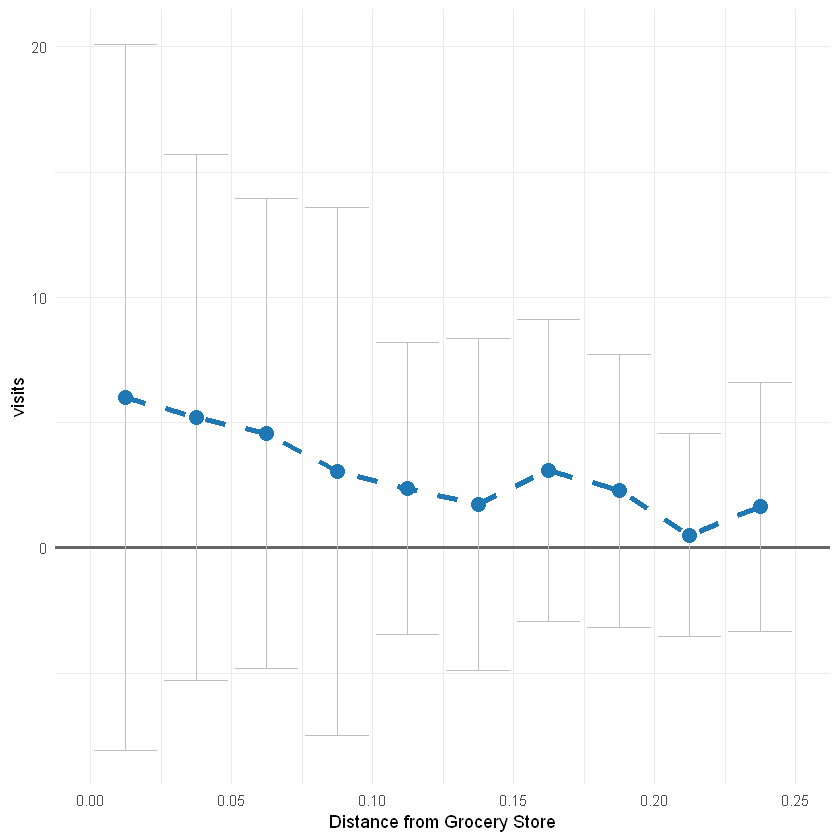

In [5]:
dat_out %>% 
  ggplot(aes(x=d, y=tau_hat)) +
  geom_hline(yintercept = 0, linewidth = 1, color = "#666666") +
  geom_errorbar(aes(ymin=tau_hat-1.96*se,ymax=tau_hat+1.96*se), color="gray") +
  geom_point(size = 4, color="#1F78B4") +
  geom_line(linewidth = 1.5, color="#1F78B4", linetype = "dashed") +
  ylab("visits") +
  xlab("Distance from Grocery Store") +
  coord_cartesian(xlim = c(0,d_bin_max)) +
  theme_minimal()

The estimated effects do not appear statistically significant.
We should *NOT* interpret the fact that all the initial estimates are above 0 as evidence that there nevertheless are positive treatment effects.
For many (outcome) variables, there is positive correlation across space.
In other words, if we have treatment in a location where, randomly, outcomes at a short distance `d=0.05` are slightly above average, then likely also outcomes at a similar distance `d=0.075` from the same location are slightly above average.
These units will be in the treated group at either distance, such that estimates across distances are likely positively correlated.

We could alternatively have looked at the inverse hyperbolic sine (`asinh`) of visits if we suspect that the treatment effect is likely to be a fixed percentage of the baseline outcome.
The inverse hyperbolic sine is similar to the log transformation, but is defined at 0.

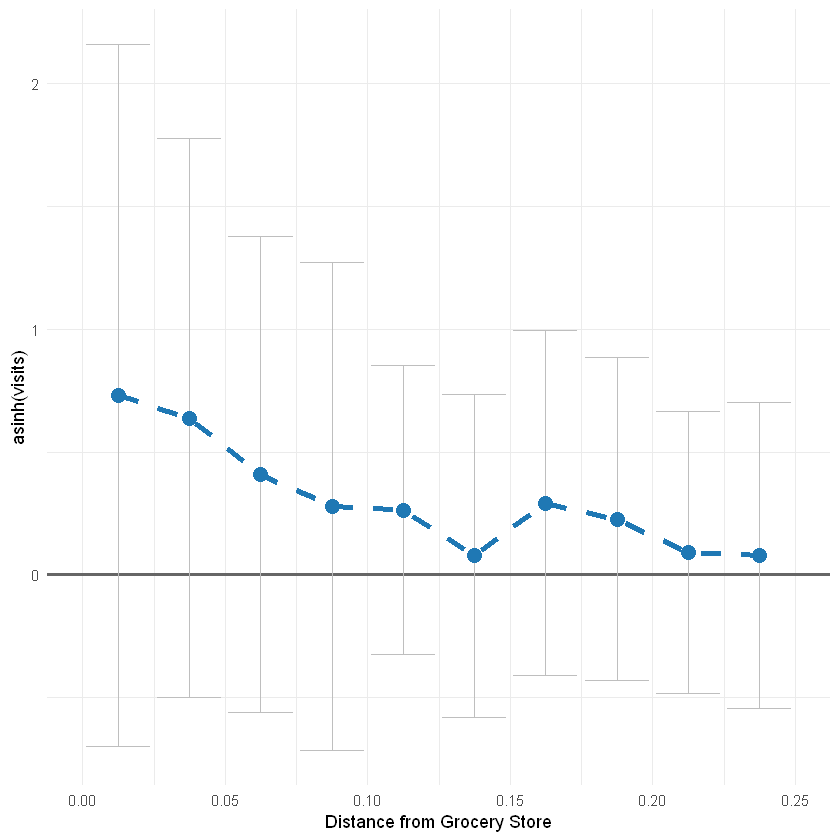

In [6]:
dat_out <- sptreat_loop(dat_D=dat_D_IS %>% rename(i=a_id,s=s_id),
             dat_S = dat_S_treat %>% rename(s=s_id),
             dat_Y = dat_Y %>% rename(i=a_id) %>% mutate(Y=asinh(Y)),
             dd = seq(d_bin_size/2,by=d_bin_size,length.out=num_bins),
             hh = d_bin_size,
             maxdeffect = dist_no_effect_var)

dat_out %>% 
  ggplot(aes(x=d, y=tau_hat)) +
  geom_hline(yintercept = 0, linewidth = 1, color = "#666666") +
  geom_errorbar(aes(ymin=tau_hat-1.96*se,ymax=tau_hat+1.96*se), color="gray") +
  geom_point(size = 4, color="#1F78B4") +
  geom_line(linewidth = 1.5, color="#1F78B4", linetype = "dashed") +
  ylab("asinh(visits)") +
  xlab("Distance from Grocery Store") +
  coord_cartesian(xlim = c(0,d_bin_max)) +
  theme_minimal()

The estimates again do not suggest that the treatment had an effect on the outcome at any distance.

Note that only the standard errors are based on the assumption that the treatment has no effect after a distance of `dist_no_effect_var`=`r dist_no_effect_var`.
We can see in either figure that the point estimates of average marginal effects are substantively close to 0 after that distance, such that this assumption at least is not immediately refuted by the data.